The aim of this notebook to make sure that `preprocess_flare_labelled.py` and
`preprocess_flare_unlabelled.py` scripts are correct.

In [1]:
import sys 
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from types import SimpleNamespace
from monai.data import Dataset
import monai.transforms as T
from src.transforms import (
    get_finetune_transforms_2d, 
    get_finetune_transforms_3d
)

In [3]:
args = SimpleNamespace(**{
    'a_min': -500, 'a_max': 500, 
    'size_x': 1.0, 'size_y': 1.0, 'size_z': 2.5,
    'min_iou': 0.95, 'max_iou': 1.0,
    'n_crops_per_ct': 1 
})


### Compare slices of preprocessed 2D and unprocessed 3D imgs (fine-tuning)

Let's make sure that 2D slices (processed with `preprocess_flare_labelled.py`)
give same images when compared to fully processing original 3D data.

In [4]:
# Take val tranforms only (no augmentations)
_, transforms_2d = get_finetune_transforms_2d(args)  # Reads already processed 2D
_, transforms_3d = get_finetune_transforms_3d(args)  # Reads original 3D

The following transforms pipeline will be used 
              for training: [<monai.transforms.io.dictionary.LoadImaged object at 0x7fee74468940>, <monai.transforms.intensity.dictionary.ScaleIntensityRanged object at 0x7feedc528280>, <monai.transforms.utility.dictionary.EnsureChannelFirstd object at 0x7fee74468f10>, <monai.transforms.utility.dictionary.EnsureTyped object at 0x7fee74468e50>, <monai.transforms.croppad.dictionary.RandCropByPosNegLabeld object at 0x7feedc5c3730>, <monai.transforms.intensity.dictionary.RandGaussianSmoothd object at 0x7feedc5c3580>, <monai.transforms.intensity.dictionary.RandScaleIntensityd object at 0x7fee744691e0>, <monai.transforms.intensity.dictionary.RandShiftIntensityd object at 0x7fee74469210>, <monai.transforms.intensity.dictionary.RandGaussianNoised object at 0x7fee74468d90>, <monai.transforms.spatial.dictionary.RandFlipd object at 0x7fee74469420>, <monai.transforms.spatial.dictionary.RandFlipd object at 0x7fee74469270>, <monai.transforms.spatial.di

/home/ditto/envs/sslct/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


Let's pick some CT ID and slice number for comparison.

In [5]:
SLICE_NO = 104
CT_ID = 'FLARE22_Tr_0007'

In [6]:
data_2d = [{
    'img': f'../data/finetune_preprocessed_2d/imgs/{CT_ID}_0000_{SLICE_NO}.png',
    'label': f'../data/finetune_preprocessed_2d/labels/{CT_ID}_{SLICE_NO}.png'
}]

data_3d = [{
    'img': f'../data/finetune/imgs/{CT_ID}_0000.nii.gz',
    'label': f'../data/finetune/labels/{CT_ID}.nii.gz'
}]

In [7]:
ds_2d = Dataset(data=data_2d, transform=transforms_2d)
sample_2d = ds_2d[0]
ds_3d = Dataset(data=data_3d, transform=transforms_3d)
sample_3d = ds_3d[0]

In [8]:
img_2d = sample_2d['img'][0, :, :].numpy()
label_2d = sample_2d['label'][0, :, :].numpy()

print(sample_3d['img'].shape[-1])

img_3d = sample_3d['img'][0, :, :, SLICE_NO].numpy()
label_3d = sample_3d['label'][0, :, :, SLICE_NO].numpy()

105


No. of slices (last dimension) seem consistent.

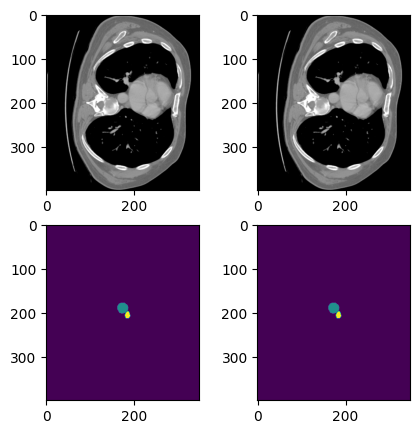

In [9]:
# np.allclose() only due to conversions between float32 and uint8
assert np.allclose(img_2d, img_3d, rtol=0, atol=5e-2)
assert np.array_equal(label_2d, label_3d)

fig, axs = plt.subplots(2, 2, figsize=(5, 5))

axs[0, 0].imshow(
    img_2d, 
    vmin=0, vmax=1, cmap='gray')
axs[0, 1].imshow(
    img_3d, 
    vmin=0, vmax=1, cmap='gray')
axs[1, 0].imshow(
    label_2d,
)
axs[1, 1].imshow(
    label_3d, 
)

plt.show()
plt.close()

It looks correct!

### Compare slices of preprocessed 2D and preprocessed 3D imgs (pretraining)

Let's also make sure that 2D slices (processed with `preprocess_flare_unlabelled.py`)
give same images when compared to processed 3D volumes (also processed with `preprocess_flare_unlabelled.py`).

Let's keep only deterministic part of corresponding SSL transforms.

In [10]:
# Deterministic part of
# src.transforms.get_ssl_transforms_2d()
transforms_2d = T.Compose([
    T.LoadImaged(
        keys=['img'],
        reverse_indexing=False  # Don't apply any rotation when loading
    ),
    T.ScaleIntensityRanged(  # 2D images stored in uint8
        keys=['img'],
        a_min=0,
        a_max=255,
        b_min=0.0, 
        b_max=1.0,
    ),
    T.EnsureChannelFirstd(
        keys=['img']
    ),
])   

# Deterministic part of
# src.transforms.get_ssl_transforms_3d()
transforms_3d = T.Compose([
    T.LoadImaged(
        keys=['img']   
    ),
    T.EnsureChannelFirstd(
        keys=['img']
    )
])  

Let's pick some CT ID and slice number for comparison.


In [11]:
SLICE_NO = 60
CT_ID = 'FLARETs_0042'

In [12]:
data_2d = [{
    'img': f'../data/ssl_preprocessed_2d/{CT_ID}_0000_{SLICE_NO}.png'
}]

data_3d = [{
    'img': f'../data/ssl_preprocessed_3d/{CT_ID}_0000.nii.gz'
}]

In [13]:
ds_2d = Dataset(data=data_2d, transform=transforms_2d)
sample_2d = ds_2d[0]
ds_3d = Dataset(data=data_3d, transform=transforms_3d)
sample_3d = ds_3d[0]

In [14]:
img_2d = sample_2d['img'][0, :, :].numpy()

print(sample_3d['img'].shape[-1])
img_3d = sample_3d['img'][0, :, :, SLICE_NO].numpy()

103


No. of slices (last dimension) seem consistent.

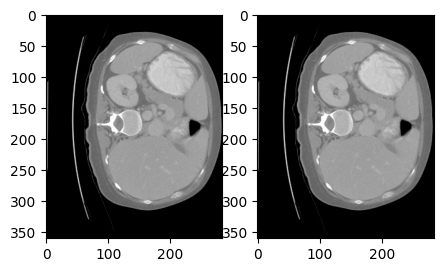

In [15]:
# np.allclose() only due to conversions between float32 and uint8
assert np.allclose(img_2d, img_3d, rtol=0, atol=5e-2)

fig, axs = plt.subplots(1, 2, figsize=(5, 5))

axs[0].imshow(
    img_2d, 
    vmin=0, vmax=1, cmap='gray')
axs[1].imshow(
    img_3d, 
    vmin=0, vmax=1, cmap='gray')

plt.show()
plt.close()

It looks correct!